# 2021/12/23
# 本代码为论文version1.0 FIG8
# 内容为u850的hov图

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import numpy as np
import xarray as xr
import sys

sys.path.append("/home/sun/mycode/module/")
from module_sun import *

In [2]:
time_slice  =  slice(100,201)
lat_slice   =  slice(10,25)
lon_slice   =  slice(55,145)
level       =  850

# 模式实验结果
path            =  "/home/sun/qomo-data/zhuang_plev/"

control_u   =  xr.open_dataset(path+"plev_con_U.nc").sel(time=time_slice,lat = lat_slice,lon = lon_slice,lev=level)
noic_u      =  xr.open_dataset(path+"plev_ic_U.nc").sel(time=time_slice,lat = lat_slice,lon = lon_slice,lev=level)
noid_u      =  xr.open_dataset(path+"plev_id_U.nc").sel(time=time_slice,lat = lat_slice,lon = lon_slice,lev=level)
noicid_u    =  xr.open_dataset(path+"plev_icid_U.nc").sel(time=time_slice,lat = lat_slice,lon = lon_slice,lev=level)

np.set_printoptions(suppress=True)
#Compute weights and take weighted average over latitude dimension
weights      =  np.cos(np.deg2rad(noic_u.lat.values))

avg_control  =  (control_u.U*weights[None, :, None]).sum(dim='lat')/np.sum(weights)
avg_noic     =  (noic_u.U*weights[None, :, None]).sum(dim='lat')/np.sum(weights)
avg_noid     =  (noid_u.U*weights[None, :, None]).sum(dim='lat')/np.sum(weights)
avg_noicid   =  (noicid_u.U*weights[None, :, None]).sum(dim='lat')/np.sum(weights)

# 坐标轴设置
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('Reds', 16)
newcolors = viridis(np.linspace(0, 1, 16))
newcmp = ListedColormap(newcolors)
newcmp.set_under('white')
newcmp.set_over('darkred')

#levels
clevs = np.arange(2,17,2)

# Tick labels
x_tick_labels = []
for xx in range(60,141,10):
    x_tick_labels.append(u''+str(xx)+"\N{DEGREE SIGN}E")

y_tick = [100,110,120,130,140,150,161,171,181,191,201]
y_label = ['10Apr','20Apr','30Apr','10May','20May','30May','10Jun','20Jun','30Jun','10Jul','20Jul']

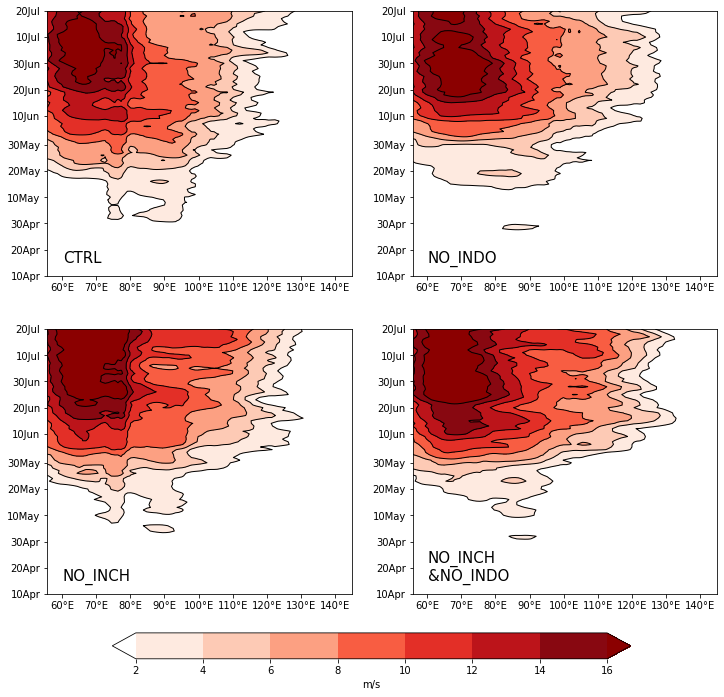

In [3]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


props = dict(boxstyle='square', edgecolor='white', facecolor='white', alpha=1)

proj    =  ccrs.PlateCarree()
fig1    =  plt.figure(figsize=(12,12))
spec1   =  fig1.add_gridspec(nrows=2,ncols=2)


j = 0
uwind  =  [avg_control,avg_noic,avg_noid,avg_noicid]
name   =  ["CTRL","NO_INCH","NO_INDO","NO_INCH\n&NO_INDO"]
    
for col in range(2):
    for row in range(2):
            ax = fig1.add_subplot(spec1[row,col])
            # 设置经纬度刻度.
            if j == 2 :
                cf   = ax.contourf(control_u.lon.values, control_u.time.values,uwind[j]*0.95, clevs, cmap=newcmp, extend='both')
                cs   = ax.contour(control_u.lon.values,  control_u.time.values,uwind[j]*0.95, clevs, colors='k', linewidths=1)
            else:
                cf   = ax.contourf(control_u.lon.values, control_u.time.values,uwind[j]*1.05, clevs, cmap=newcmp, extend='both')
                cs   = ax.contour(control_u.lon.values,  control_u.time.values,uwind[j]*1.05, clevs, colors='k', linewidths=1)
            ax.text(0.05,0.05,name[j],transform=ax.transAxes,bbox=props,fontsize=15)
        
            j += 1
            ax.set_xticks(np.arange(60,141,10))
            ax.set_xticklabels(x_tick_labels)
            ax.tick_params(labelsize=10)

            ax.set_yticks(y_tick)
            ax.set_yticklabels(y_label)


fig1.subplots_adjust(top=0.8) 
cbar_ax = fig1.add_axes([0.2, 0.05, 0.6, 0.03]) 
fig1.colorbar(cf, cax=cbar_ax, shrink=0.1, pad=0.01, orientation='horizontal',label='m/s')


plt.savefig("/home/sun/paint/lunwen/version1.0/fig8_version1.0_model_u850_hov.pdf", bbox_inches='tight', dpi=300)
plt.show()

# 绘制观测的u850 hov图

In [4]:
path  =  "/home/sun/qomo-data/year_mean/multi/"
file_list  =  os.listdir(path) ; file_list.sort()

f0    =  xr.open_dataset(path+"0101.climate.nc").sel(lev=850)

merra_u  =  np.zeros((365,len(f0.lat),len(f0.lon)))
for i in range(365):
    ff  =  xr.open_dataset(path+file_list[i]).sel(lev=850)
    merra_u[i,:]  =  ff.U.data[0,:]
    


In [8]:
ncfile  =  xr.Dataset(
    {
        "merra_u": (["time", "lat", "lon"], merra_u),
    },
    coords={
        "lon": (["lon"], f0.lon.data),
        "lat": (["lat"], f0.lat.data),
        "time": (["time"], np.linspace(1,365,365)),
    },
)

obs_u    =  ncfile.sel(time=time_slice,lat = lat_slice,lon = lon_slice)

np.set_printoptions(suppress=True)
#Compute weights and take weighted average over latitude dimension
weights      =  np.cos(np.deg2rad(obs_u.lat.values))

avg_obs  =  (obs_u.merra_u*weights[None, :, None]).sum(dim='lat')/np.sum(weights)

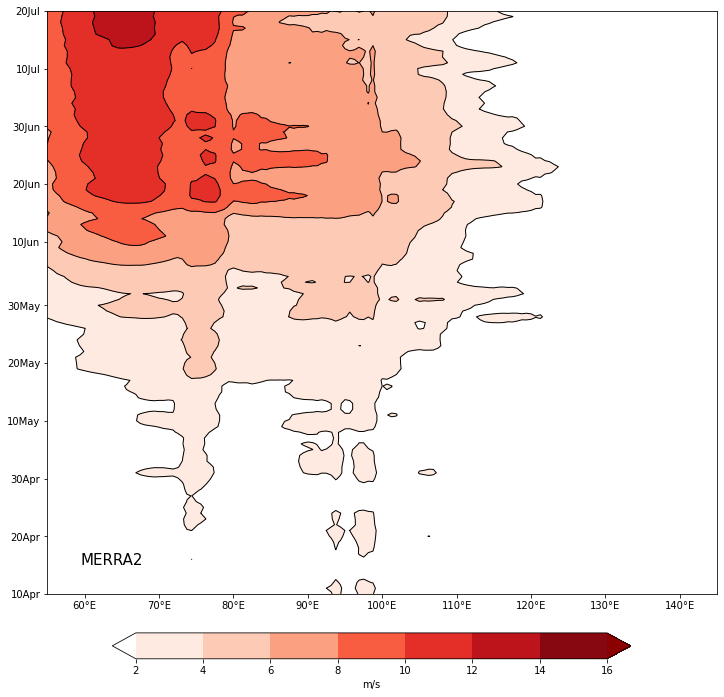

In [16]:
proj    =  ccrs.PlateCarree()
fig    =  plt.figure(figsize=(12,12))

ax = fig.add_subplot()
# 设置经纬度刻度.
cf   = ax.contourf(obs_u.lon.values, obs_u.time.values,avg_obs*0.95, clevs, cmap=newcmp, extend='both')
cs   = ax.contour(obs_u.lon.values,  obs_u.time.values,avg_obs*0.95, clevs, colors='k', linewidths=1)
ax.text(0.05,0.05,"MERRA2",transform=ax.transAxes,bbox=props,fontsize=15)

ax.set_xticks(np.arange(60,141,10))
ax.set_xticklabels(x_tick_labels)
ax.tick_params(labelsize=10)

ax.set_yticks(y_tick)
ax.set_yticklabels(y_label)


fig.subplots_adjust(top=0.8) 
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.03]) 
fig1.colorbar(cf, cax=cbar_ax, shrink=0.1, pad=0.01, orientation='horizontal',label='m/s')


plt.savefig("/home/sun/paint/lunwen/version1.2/fig9_version1.2_observation_u850_hov.pdf", bbox_inches='tight', dpi=300)
plt.show()

In [10]:
avg_obs.shape

(102, 145)